# Titanic Survival Prediction – End‑to‑End Project


This notebook builds a complete Titanic survival prediction pipeline using the Kaggle dataset.

**  Steps covered:  **

1) Load dataset (`train.csv`, `test.csv`)  

2) EDA with plots  

3) Preprocessing and feature engineering  

4) Model training (LogReg, RandomForest, XGBoost, SVM)  

5) Cross‑validation + hyperparam tuning  

6) Final prediction and `submission.csv`  



> **Note:** Place `train.csv` and `test.csv` from Kaggle in the same folder as this notebook before running.


In [2]:

# ============================================================
#                     1) Imports & Setup
# ============================================================


import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# XGBoost (install xgboost if needed)
try:
    from xgboost import XGBClassifier
except Exception as e:
    XGBClassifier = None
    print("xgboost not available. Install with: pip install xgboost")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:

# ============================================================
# 2)                          Load Data
# ============================================================
assert os.path.exists("train.csv"), "Place Kaggle's train.csv next to this notebook."
assert os.path.exists("test.csv"), "Place Kaggle's test.csv next to this notebook."

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

print(train.shape, test.shape)
train.head()


(712, 12) (179, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
1,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
2,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
3,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
4,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


In [4]:

# ============================================================
# 3)                Feature Engineering 
# ============================================================
import re

def extract_title(name: str) -> str:
    if pd.isna(name):
        return "None"
    m = re.search(r",\s*([^\.]+)\.", name)
    return m.group(1).strip() if m else "None"

def unify_title(t):
    mapping = {
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Royalty', 'Countess': 'Royalty', 'Dona':'Royalty',
        'Sir': 'Royalty', 'Jonkheer': 'Royalty', 'Don':'Royalty',
        'Capt':'Officer','Col':'Officer','Major':'Officer','Dr':'Officer','Rev':'Officer'
    }
    return mapping.get(t, t)

def cabin_deck(cabin):
    if pd.isna(cabin) or not isinstance(cabin, str):
        return "Unknown"
    return cabin[0]

def ticket_prefix(ticket):
    if pd.isna(ticket) or not isinstance(ticket, str):
        return "NONE"
    # remove dots and slashes, take leading letters as prefix
    t = ticket.replace(".", "").replace("/", "").split()
    prefix = "".join([p for p in t if not p.isdigit()])
    return prefix.upper() if prefix else "NONE"

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Title
    df["Title"] = df["Name"].apply(extract_title).apply(unify_title)
    # FamilySize
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    # Cabin Deck
    df["Deck"] = df["Cabin"].apply(cabin_deck)
    # Ticket Prefix
    df["TicketPrefix"] = df["Ticket"].apply(ticket_prefix)
    # Fare per person (approx)
    df["FarePerPerson"] = df["Fare"] / df["FamilySize"].replace(0, 1)
    return df

# Apply to train/test
train_fe = add_features(train)
test_fe  = add_features(test)

train_fe.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Deck,TicketPrefix,FarePerPerson
0,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,Mr,1,1,C,NONE,28.500000
1,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S,Mr,1,1,Unknown,NONE,13.000000
2,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S,Mr,1,1,Unknown,STONO,7.925000
3,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,Mr,2,0,Unknown,NONE,3.927100
4,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Miss,7,0,Unknown,NONE,4.467857


Missing values (train):
PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              140
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            553
Embarked           2
Title              0
FamilySize         0
IsAlone            0
Deck               0
TicketPrefix       0
FarePerPerson      0
AgeGroup         140
dtype: int64

Missing values (test):
PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age               37
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            134
Embarked           0
Title              0
FamilySize         0
IsAlone            0
Deck               0
TicketPrefix       0
FarePerPerson      0
dtype: int64


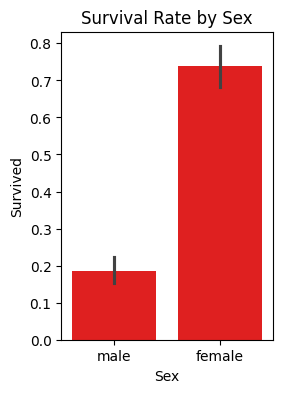

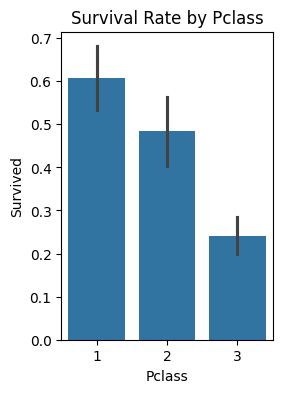

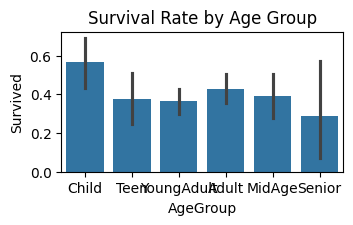

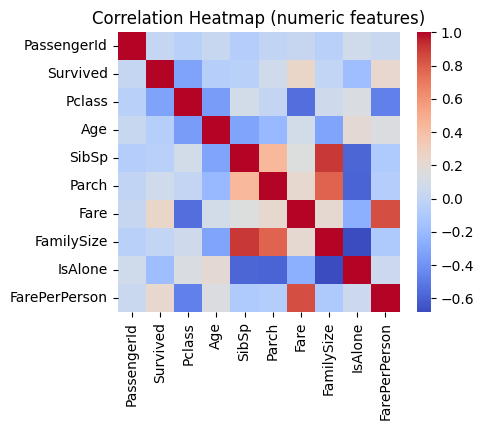

In [6]:

# ============================================================
# 4)           EDA – Quick Glance and Missing Values
# ============================================================
print("Missing values (train):")
print(train_fe.isna().sum())

print("\nMissing values (test):")
print(test_fe.isna().sum())

# Survival rates by gender

fig = plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
sns.barplot(x="Sex", y="Survived", data=train_fe ,color='r')
plt.title("Survival Rate by Sex")
plt.show()

# Survival rates by class
fig = plt.figure(figsize=(6,4))
plt.subplot(1,2,2)
sns.barplot(x="Pclass", y="Survived", data=train_fe)
plt.title("Survival Rate by Pclass")
plt.show()

# Survival vs age groups
train_fe["AgeGroup"] = pd.cut(train_fe["Age"], bins=[0,12,18,30,45,60,80], labels=["Child","Teen","YoungAdult","Adult","MidAge","Senior"])
fig = plt.figure(figsize=(8,4))
plt.subplot(2,2,3)
sns.barplot(x="AgeGroup", y="Survived", data=train_fe )
plt.title("Survival Rate by Age Group")
plt.show()

# Correlation heatmap (numeric features)
num_cols = train_fe.select_dtypes(include=[np.number]).columns.tolist()
corr = train_fe[num_cols].corr()
fig = plt.figure(figsize=(10,8))
plt.subplot(2,2,4)
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features)")
plt.show()


<Axes: xlabel='Fare', ylabel='Density'>

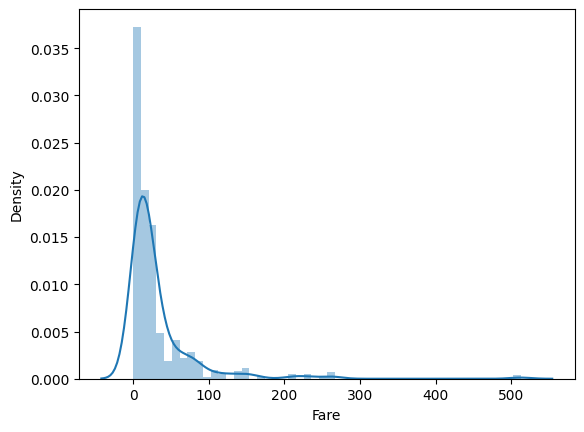

In [13]:
sns.distplot(train_fe["Fare"])

In [16]:
train_fe.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            553
Embarked           0
Title              0
FamilySize         0
IsAlone            0
Deck               0
TicketPrefix       0
FarePerPerson      0
AgeGroup         140
dtype: int64

In [18]:

# ============================================================
# 5)                 Preprocessing Pipelines
# ============================================================
target = "Survived"

# Columns
numeric_features = ["Age","Fare","FamilySize"]
categorical_features = ["Pclass","Sex","Embarked","Title","Deck","TicketPrefix","IsAlone"]

# Impute Fare (sometimes missing in test)
train_fe["Fare"] = train_fe["Fare"].fillna(train_fe["Fare"].median())
test_fe["Fare"]  = test_fe["Fare"].fillna(train_fe["Fare"].median())

# Embarked imputation
train_fe["Embarked"] = train_fe["Embarked"].fillna(train_fe["Embarked"].mode()[0])
test_fe["Embarked"]  = test_fe["Embarked"].fillna(train_fe["Embarked"].mode()[0])

# Age imputation smart: by Title x Pclass x Sex median on train
age_medians = train_fe.groupby(["Title","Pclass","Sex"])["Age"].median()
def impute_age(row):
    if pd.isna(row["Age"]):
        return age_medians.get((row["Title"], row["Pclass"], row["Sex"]), train_fe["Age"].median())
    return row["Age"]

train_fe["Age"] = train_fe.apply(impute_age, axis=1)
test_fe["Age"]  = test_fe.apply(impute_age, axis=1)

X = train_fe.drop(columns=[target])
y = train_fe[target].astype(int)

# For ColumnTransformer, we must list exact columns that exist in X
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


In [20]:

# ============================================================
# 6)              Train/Validation Split & Models
# ============================================================


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

models = {}

# Logistic Regression
models["LogReg"] = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=200, random_state=RANDOM_STATE))
])

# Random Forest
models["RF"] = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))
])

# SVM
models["SVM"] = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", SVC(probability=True, random_state=RANDOM_STATE))
])


# XGBoost (if available)
if XGBClassifier is not None:
    models["XGB"] = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", XGBClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8,
            random_state=RANDOM_STATE, eval_metric="logloss"))
    ])

# Quick baseline training & validation scores
def evaluate(model, X_tr, y_tr, X_va, y_va, name):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_va)
    proba = model.predict_proba(X_va)[:,1] if hasattr(model, "predict_proba") else None
    metrics = {
        "accuracy": accuracy_score(y_va, pred),
        "precision": precision_score(y_va, pred),
        "recall": recall_score(y_va, pred),
        "f1": f1_score(y_va, pred),
    }
    if proba is not None:
        metrics["roc_auc"] = roc_auc_score(y_va, proba)
    print(f"\n{name}:", metrics)
    return metrics

results = {}
for name, pipe in models.items():
    results[name] = evaluate(pipe, X_train, y_train, X_valid, y_valid, name)

pd.DataFrame(results).T.sort_values("f1", ascending=False)



LogReg: {'accuracy': 0.8601398601398601, 'precision': 0.8541666666666666, 'recall': 0.7592592592592593, 'f1': 0.803921568627451, 'roc_auc': np.float64(0.9017894298793174)}

RF: {'accuracy': 0.8461538461538461, 'precision': 0.8333333333333334, 'recall': 0.7407407407407407, 'f1': 0.7843137254901961, 'roc_auc': np.float64(0.8985642946317104)}

SVM: {'accuracy': 0.8671328671328671, 'precision': 0.8723404255319149, 'recall': 0.7592592592592593, 'f1': 0.8118811881188119, 'roc_auc': np.float64(0.9119850187265918)}

XGB: {'accuracy': 0.8321678321678322, 'precision': 0.8125, 'recall': 0.7222222222222222, 'f1': 0.7647058823529411, 'roc_auc': np.float64(0.881190178942988)}


,accuracy,precision,recall,f1,roc_auc
SVM,0.867133,0.872340,0.759259,0.811881,0.911985
LogReg,0.860140,0.854167,0.759259,0.803922,0.901789
RF,0.846154,0.833333,0.740741,0.784314,0.898564
XGB,0.832168,0.812500,0.722222,0.764706,0.881190


In [21]:

# ============================================================================================
# 7)  
#                Cross-Validation & Hyperparameter Tuning (light grids)
#                (This can take a few minutes; adjust as needed)

# ======================================================================================


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grids = {
    "LogReg": {
        "clf__C": [0.1, 1.0, 3.0, 10.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    },
    "RF": {
        "clf__n_estimators": [200, 400, 700],
        "clf__max_depth": [None, 4, 6, 8],
        "clf__min_samples_split": [2, 5, 10]
    },
    "SVM": {
        "clf__C": [0.5, 1, 3],
        "clf__kernel": ["rbf", "linear"],
        "clf__gamma": ["scale"]
    },
}

if "XGB" in models:
    param_grids["XGB"] = {
        "clf__n_estimators": [300, 500, 800],
        "clf__max_depth": [3, 4, 5],
        "clf__learning_rate": [0.03, 0.05, 0.1],
        "clf__subsample": [0.7, 0.8, 1.0],
        "clf__colsample_bytree": [0.7, 0.8, 1.0],
    }

grid_results = {}
best_estimators = {}

for name, pipe in models.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(pipe, param_grids[name], scoring="f1", cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    grid_results[name] = {"best_score": grid.best_score_, "best_params": grid.best_params_}
    best_estimators[name] = grid.best_estimator_
    print("Best F1:", grid.best_score_)
    print("Best params:", grid.best_params_)

pd.DataFrame(grid_results).T.sort_values("best_score", ascending=False)



Tuning LogReg...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best F1: 0.7816570640261685
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Tuning RF...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best F1: 0.7679057938746936
Best params: {'clf__max_depth': 8, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

Tuning SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best F1: 0.7755362629352598
Best params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

Tuning XGB...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best F1: 0.7698504268246003
Best params: {'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.03, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 0.8}


,best_score,best_params
LogReg,0.781657,"{'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__so..."
SVM,0.775536,"{'clf__C': 1, 'clf__gamma': 'scale', 'clf__ker..."
XGB,0.76985,"{'clf__colsample_bytree': 0.7, 'clf__learning_..."
RF,0.767906,"{'clf__max_depth': 8, 'clf__min_samples_split'..."


In [22]:

# =================================================================================
# 8)              Select Best Model & Fit on Full Training Data
# ==========================================================================

scores = {name: info["best_score"] for name, info in grid_results.items()}
best_name = max(scores, key=scores.get)
best_model = best_estimators[best_name]
print(f"Best model: {best_name} with CV F1={scores[best_name]:.4f}")

# Fit on all training data
best_model.fit(X, y)

# Save model (optional)
import joblib
joblib.dump(best_model, "best_model.pkl")
print("Saved best_model.pkl")


Best model: LogReg with CV F1=0.7817
Saved best_model.pkl


In [23]:

# ============================================================
# 9)            Predict on Test & Create submission.csv
# ============================================================


test_pred = best_model.predict(test_fe)
submission = pd.DataFrame({
    "PassengerId": test_fe["PassengerId"],
    "Survived": test_pred.astype(int)
})
submission.to_csv("submission.csv", index=False)
submission.head(), submission.shape


(   PassengerId  Survived
 0          710         1
 1          440         0
 2          841         0
 3          721         1
 4           40         1,
 (179, 2))

### Done!
- File `submission.csv` has been created.
- You can submit it to Kaggle and compare your score.
- Explore more features and tuning to push performance.